# AI EU Project #

In [1]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_excel('pstw_dataset.xlsx')

## Drop unnused columns ##

In [2]:
# Ensures all the projects are within AI 
df = df[df['Primary Technology'].str.lower() == 'artificial intelligence']

# Replaces Pilot phase with pilot for consistensy
df[' Status'] = df[' Status'].replace({'Pilot phase': 'Pilot'})

# Resets the indexing so that it will match the other data when modelling
df = df.reset_index(drop=True)

# This will be the hyperparameter used when modelling
df_y = df[' Status']

# All columns needed for the project
columns = [
    "Geographical extent",
    "Functions of Government (COFOG level I)",
    "Functions of Government (COFOG level II)",
    "Process type",
    "Application type",
    "Cross Border",
    "Cross Sector",
    "Interaction",
    "Increase quality of PSI and services",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    "AI Classification (I)",
    "AI Classification Subdomain (II) (main)",
    "AI Classification Subdomain (II) (Other I)",
    "AI Keywords",
    "Collaboration type",
    "Funding source"
]

# Columns to replace that contains X:s
x_columns = [
    # "Improved Public Service",
    # "Personalized Services",
    # "Public (citizen)-centered services",
    "Increase quality of PSI and services",
    # "More responsive, efficient, and cost-effective public services",
    # "New services or channels",
    # "Improved Administrative Efficiency",
    # "Cost-reduction",
    # "Responsiveness of government operation",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    # "Open government capabilities",
    # "Increased transparency of public sector operations"
]

# Fixes columns that are misspelled
df_selected = df[columns].copy()
for column in df_selected.columns:
   if df_selected[column].dtype == 'object':
      df_selected.loc[:, column] = df_selected[column].str.strip().str.lower()

# Replaces X/ x with 1 or 0 to ease dummy-encoding
def translate_x(dataFrame, column):
  dataFrame.loc[:, column] = dataFrame[column].replace({
      "x": 1,
      "X": 1,
      "\xa0": 0,
      " ": 0,
      np.nan: 0
  })
  dataFrame[column] = dataFrame[column].astype(str).str.strip().replace('', '0')
    
  # Convert to integer safely
  dataFrame[column] = pd.to_numeric(dataFrame[column], errors='coerce').fillna(0).astype(int)
 

# Translates X in for the right columns
for column in x_columns:
    translate_x(df_selected, column)

/tmp/ipykernel_1361834/1720681899.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame.loc[:, column] = dataFrame[column].replace({
/tmp/ipykernel_1361834/1720681899.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame.loc[:, column] = dataFrame[column].replace({


In [3]:
from sklearn.preprocessing import LabelEncoder

# Dummy encoding
df_oh = pd.get_dummies(df_selected, dtype=int)

# Resets the index so that it will match when modelling
df_oh = df_oh.reset_index(drop=True)

print(df_oh.info())
print(df_y.unique())

# Label encoding y-data
le = LabelEncoder()
y_encoded = le.fit_transform(df_y)

# Assigning data to variables
y_status = y_encoded
X_status = df_oh


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Columns: 248 entries, Increase quality of PSI and services to Funding source_regional-funded project
dtypes: int64(248)
memory usage: 3.0 MB
None
['Not in use' 'Implemented' 'Pilot' 'Planned' 'In development']


### Duration of years ###

Here we are creating a variable for the duration of years for projects that have the status of implemented or pilot.

With that data we can make a regressional model for predicting the time it takes for certain projects to reach that status.

In [4]:
# Selects only the rows containing the right status
mask = df[' Status'].isin(['Implemented', 'Pilot'])

# Makes a new column containing the amount of years
df_duration = df.loc[mask].copy()
X_years = df_oh.loc[mask].copy()

df_duration['Duration_years'] = df_duration["End Year"].dropna() - df_duration["Start Year"]

# Saves it as a variable
y_years = df_duration['Duration_years'].dropna()
print(y_years.head())

X_years = X_years.loc[y_years.index]

print(X_years.shape, y_years.shape)

8     0
17    2
25    1
37    1
51    0
Name: Duration_years, dtype: object
(438, 248) (438,)


In [5]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding for the target variable
# df_oe = pd.DataFrame()
encoder = OrdinalEncoder()
df_oe = pd.DataFrame(encoder.fit_transform(df_selected), columns=df_selected.columns)
# df_oe = df_oe.astype(int)

print(df_oe)



      Geographical extent  Functions of Government (COFOG level I)  \
0                     2.0                                      9.0   
1                     2.0                                      4.0   
2                     2.0                                      3.0   
3                     3.0                                      1.0   
4                     1.0                                      4.0   
...                   ...                                      ...   
1570                  1.0                                      8.0   
1571                  2.0                                      4.0   
1572                  1.0                                      4.0   
1573                  2.0                                      9.0   
1574                  2.0                                      9.0   

      Functions of Government (COFOG level II)  Process type  \
0                                         56.0           4.0   
1                              

## Splitting and Scaling ##

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train_val_status, X_test_status, y_train_val_status, y_test_status = train_test_split(
    X_status, y_status, test_size=0.2, random_state=42
)

# Then split train_val into train and validation
X_train_status, X_val_status, y_train_status, y_val_status = train_test_split(
    X_train_val_status, y_train_val_status,
    test_size=0.25,
    stratify=y_train_val_status,
    random_state=42
)

# Time dataset splitting
X_train_val_years, X_test_years, y_train_val_years, y_test_years = train_test_split(
    X_years, y_years, test_size=0.2, random_state=42
)

X_train_years, X_val_years, y_train_years, y_val_years = train_test_split(
    X_train_val_years, y_train_val_years,
    test_size=0.25,
    random_state=42
)

# Scaling data
scaler = StandardScaler()
X_train_status = scaler.fit_transform(X_train_status)
X_val_status = scaler.transform(X_val_status)
X_test_status = scaler.transform(X_test_status)
X_train_val_status = scaler.transform(X_train_val_status)

# Scaling data for years
X_train_val_years = scaler.fit_transform(X_train_val_years)
X_val_years = scaler.transform(X_val_years)
X_test_years = scaler.transform(X_test_years)
X_train_val_years = scaler.transform(X_train_val_years)

/home/celvin/miniconda3/envs/python_basics_env/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Feature Importance ##

Index(['Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems',
       'Geographical extent_across countries', 'Geographical extent_local',
       'Geographical extent_national', 'Geographical extent_regional',
       'Functions of Government (COFOG level I)_defence',
       'Functions of Government (COFOG level I)_economic affairs',
       'Functions of Government (COFOG level I)_education',
       ...
       'Collaboration type_other pas',
       'Collaboration type_private corporation',
       'Collaboration type_sandboxing', 'Collaboration type_universities',
       'Collaboration type_universities/research organisations',
       'Funding source_eu-funded project',
       'Funding source_funded with own resources',
       'Funding source_local-funded project',
       'Funding source_national-funded project',
       'Funding source_regional-funded project'],
      dtype='object', length=248)


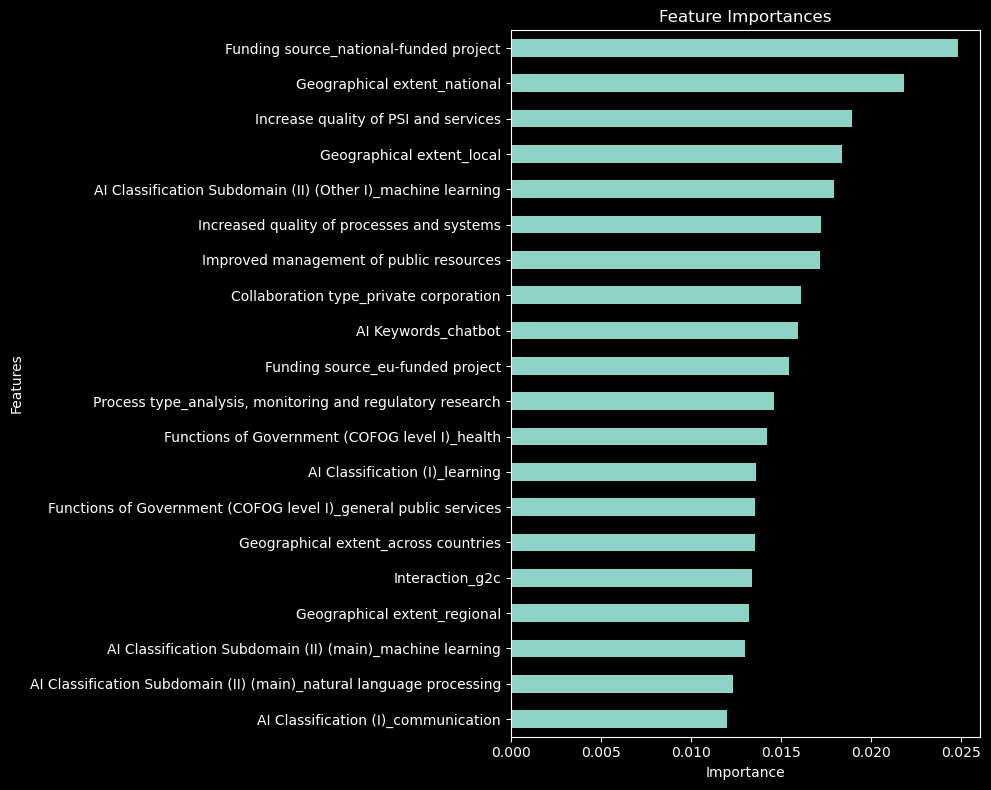

In [7]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


rm_model = RandomForestClassifier()

rm_model.fit(X_train_status, y_train_status)

importances = rm_model.feature_importances_
feature_names = X_status.columns

print(feature_names)
feat_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance': importances
})

filtered_df = feat_df[feat_df['Importance'] > 0.012]

filtered_df = filtered_df.sort_values(by='Importance', ascending=True)

# print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

plt.show() 

Classes in y_val: [0 1 2 3 4]
Index(['Geographical extent', 'Functions of Government (COFOG level I)',
       'Functions of Government (COFOG level II)', 'Process type',
       'Application type', 'Cross Border', 'Cross Sector', 'Interaction',
       'Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems', 'AI Classification (I)',
       'AI Classification Subdomain (II) (main)',
       'AI Classification Subdomain (II) (Other I)', 'AI Keywords',
       'Collaboration type', 'Funding source'],
      dtype='object')
[0.07820752 0.08382791 0.1303661  0.04752827 0.09624366 0.01554524
 0.01835834 0.03328323 0.02309647 0.02519852 0.02567225 0.06371562
 0.0711602  0.09815007 0.07626226 0.06463721 0.04874713]


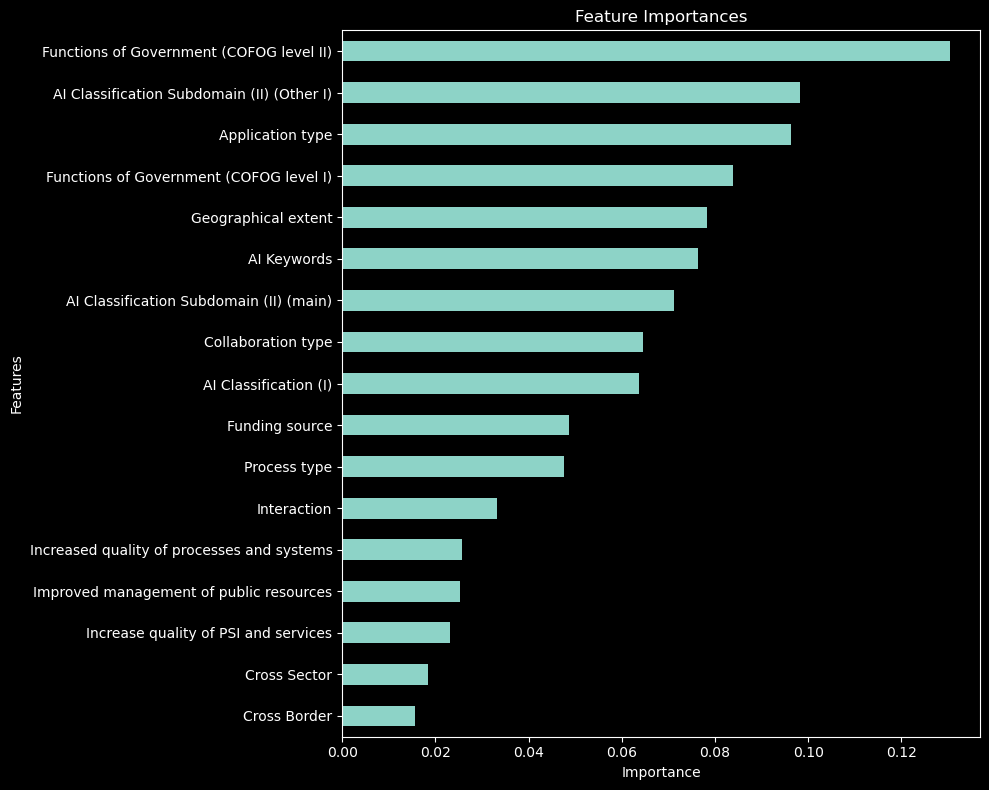

In [8]:
y_fi = y_encoded
X_fi = df_oe

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, random_state=42, test_size=0.2)
X_train_fi, X_val_fi, y_train_fi, y_val_fi = train_test_split(X_train_val_fi, y_train_val_fi, random_state=42, test_size=0.2) 

print("Classes in y_val:", np.unique(y_val_fi))


X_train_fi = scaler.fit_transform(X_train_fi)
X_val_fi = scaler.fit_transform(X_val_fi) 
X_test_fi = scaler.fit_transform(X_test_fi)

rm_model.fit(X_train_fi, y_train_fi)

importances = rm_model.feature_importances_
feature_names = X_fi.columns

print(feature_names)
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
    })

filtered_df = feat_df
filtered_df = filtered_df.sort_values(by='Importance', ascending=True)
print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Training Classification Models ##


Best Estimator:
SVC(C=10, class_weight='balanced', gamma=0.01)

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       127
           1       0.39      0.24      0.30        37
           2       0.00      0.00      0.00        11
           3       0.59      0.68      0.63       135
           4       0.50      0.20      0.29         5

    accuracy                           0.56       315
   macro avg       0.41      0.34      0.36       315
weighted avg       0.53      0.56      0.54       315



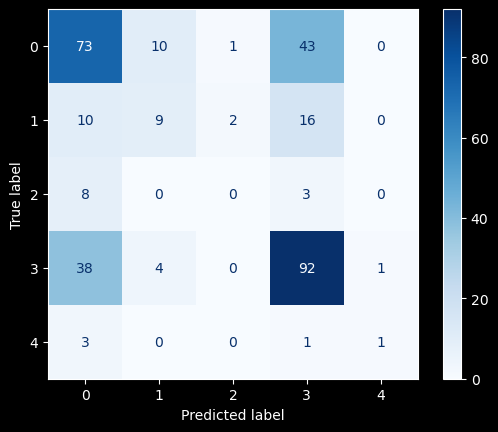


Best Estimator:
RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=50, random_state=42)

              precision    recall  f1-score   support

           0       0.61      0.62      0.61       127
           1       0.38      0.32      0.35        37
           2       0.17      0.09      0.12        11
           3       0.63      0.66      0.64       135
           4       0.17      0.20      0.18         5

    accuracy                           0.58       315
   macro avg       0.39      0.38      0.38       315
weighted avg       0.57      0.58      0.57       315



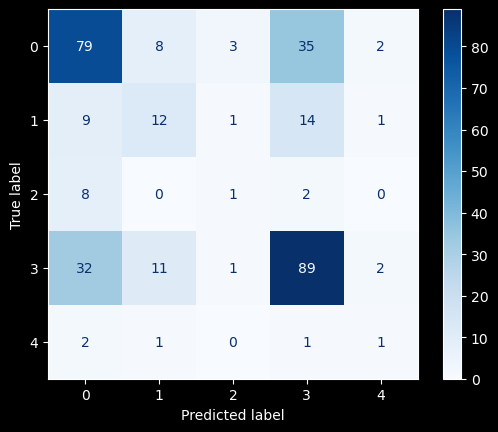


Best Estimator:
ExtraTreesClassifier(class_weight='balanced', min_samples_split=5,
                     n_estimators=150, random_state=42)

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       127
           1       0.39      0.32      0.35        37
           2       0.50      0.27      0.35        11
           3       0.63      0.65      0.64       135
           4       0.12      0.20      0.15         5

    accuracy                           0.58       315
   macro avg       0.45      0.41      0.42       315
weighted avg       0.58      0.58      0.58       315



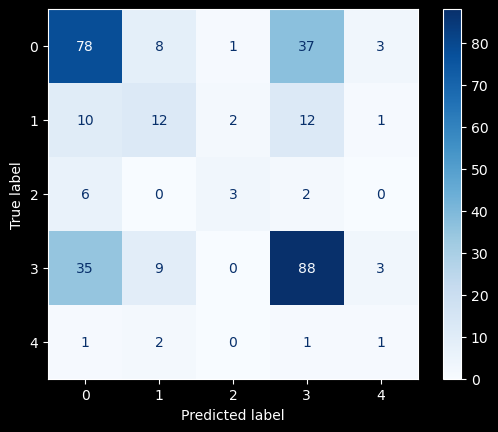


Best performing model: ExtraTreesClassifier(class_weight='balanced', min_samples_split=5,
                     n_estimators=150, random_state=42)

Model precision score: 0.45


In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, mean_absolute_error, root_mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

svc = SVC(class_weight='balanced')
rm_cl = RandomForestClassifier(random_state=42, class_weight='balanced')
et_cl = ExtraTreesClassifier(random_state=42, class_weight='balanced')

hypergrid_svc = {
  'kernel': ['rbf', 'poly', 'sigmoid'],
  'C': [0.1, 1, 10],
  'gamma': [0.01, 0.1, 0.5, 1]
}

hypergrid_rm = {
  'n_estimators': [10, 50, 100, 150],
  'min_samples_split': [2, 5, 10]
}

svc_model_gs = GridSearchCV(svc, hypergrid_svc, scoring='f1_macro', cv=3)
rm_model_gs = GridSearchCV(rm_cl, hypergrid_rm, scoring='f1_macro', cv=3)
et_model_gs = GridSearchCV(et_cl, hypergrid_rm, scoring='f1_macro', cv=3)

models_score = []

for clf in (svc_model_gs, rm_model_gs, et_model_gs):
  # Trains on the model on training data
  clf.fit(X_train_status, y_train_status)
  y_pred_val_status = clf.predict(X_val_status)
  
  # Prints out scoring for accuracy, precision, recall and f1 for each model
  prec_score = precision_score(y_val_status, y_pred_val_status, average='macro', zero_division=0)
  print(f'\nBest Estimator:\n{clf.best_estimator_}')
  print(f'\n{classification_report(y_val_status, y_pred_val_status, zero_division=0)}')

  cm = confusion_matrix(y_val_status, y_pred_val_status)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap="Blues", values_format='d')
  plt.show()

  models_score.append({
        'model': clf,
        'score': prec_score
  })

# Saves the best performing model based on accuracy
best_prec_model = max(models_score, key=lambda x: x['score'])
print(f'\nBest performing model: {best_prec_model['model'].best_estimator_}')
print(f'\nModel precision score: {best_prec_model['score']:.2f}')
best_model = best_prec_model['model'].best_estimator_

## Best Model Training ##

In [10]:
# bästa modellen tränas om på train och val
best_model = best_model.fit(X_val_status, y_val_status)

#modell testas på testdata
bm_test_pred = best_model.predict(X_test_status)

print(f'\nBest Estimator:\n{clf.best_estimator_}')
print(f'\n{classification_report(y_val_status, y_pred_val_status, zero_division=0)}')


Best Estimator:
ExtraTreesClassifier(class_weight='balanced', min_samples_split=5,
                     n_estimators=150, random_state=42)

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       127
           1       0.39      0.32      0.35        37
           2       0.50      0.27      0.35        11
           3       0.63      0.65      0.64       135
           4       0.12      0.20      0.15         5

    accuracy                           0.58       315
   macro avg       0.45      0.41      0.42       315
weighted avg       0.58      0.58      0.58       315



## Training Linear Models ##

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Converts data back to dataframes
X_val_years = pd.DataFrame(X_val_years, columns=X_train_years.columns)
X_test_years = pd.DataFrame(X_test_years, columns=X_train_years.columns)

lin_reg = LinearRegression()
rm_reg = RandomForestRegressor()

# Paramgrid for random forest
hypergrid_reg = {
  'n_estimators': [10, 50, 100, 150],
  'min_samples_split': [2, 5, 10]
}

# Gridsearch for the best parameters for random forest
grid_rm_reg = GridSearchCV(rm_reg, hypergrid_reg)

# Training and predicting random forest
grid_rm_reg.fit(X_train_years, y_train_years)
y_pred_years_gs = grid_rm_reg.predict(X_val_years)

# Scoring for random forest
print("Random Forest Validation MAE:", round(mean_absolute_error(y_val_years, y_pred_years_gs), 2))
print("Random Forest Validation RMSE:", round(root_mean_squared_error(y_val_years, y_pred_years_gs), 2))

# Training on validation for random forest
grid_rm_reg.fit(X_val_years, y_val_years)
y_pred_years_gs = grid_rm_reg.predict(X_test_years)
# Scoring for random forest
print("Random Forest Test MAE:", round(mean_absolute_error(y_test_years, y_pred_years_gs), 2))
print("Random Forest Test RMSE:", round(root_mean_squared_error(y_test_years, y_pred_years_gs), 2))

# Training and predicting linear regression
lin_reg.fit(X_train_years, y_train_years)
y_pred_years_log = lin_reg.predict(X_val_years)
# Scoring for linear regression
print("Linear Regression Validation MAE:", round(mean_absolute_error(y_val_years, y_pred_years_log), 2))
print("Linear Regression Validation RMSE:", round(root_mean_squared_error(y_val_years, y_pred_years_log), 2))

lin_reg.fit(X_val_years, y_val_years)
y_pred_years_log = lin_reg.predict(X_test_years)
# Scoring for linear regression
print("Linear Regression Test MAE:", round(mean_absolute_error(y_test_years, y_pred_years_log), 2))
print("Linear Regression Test RMSE:", round(root_mean_squared_error(y_test_years, y_pred_years_log), 2))

Random Forest Validation MAE: 1.06
Random Forest Validation RMSE: 2.08
Random Forest Test MAE: 1.06
Random Forest Test RMSE: 1.72
Linear Regression Validation MAE: 7.99
Linear Regression Validation RMSE: 11.25
Linear Regression Test MAE: 3.34
Linear Regression Test RMSE: 4.63


## Plotting Linear Models ##

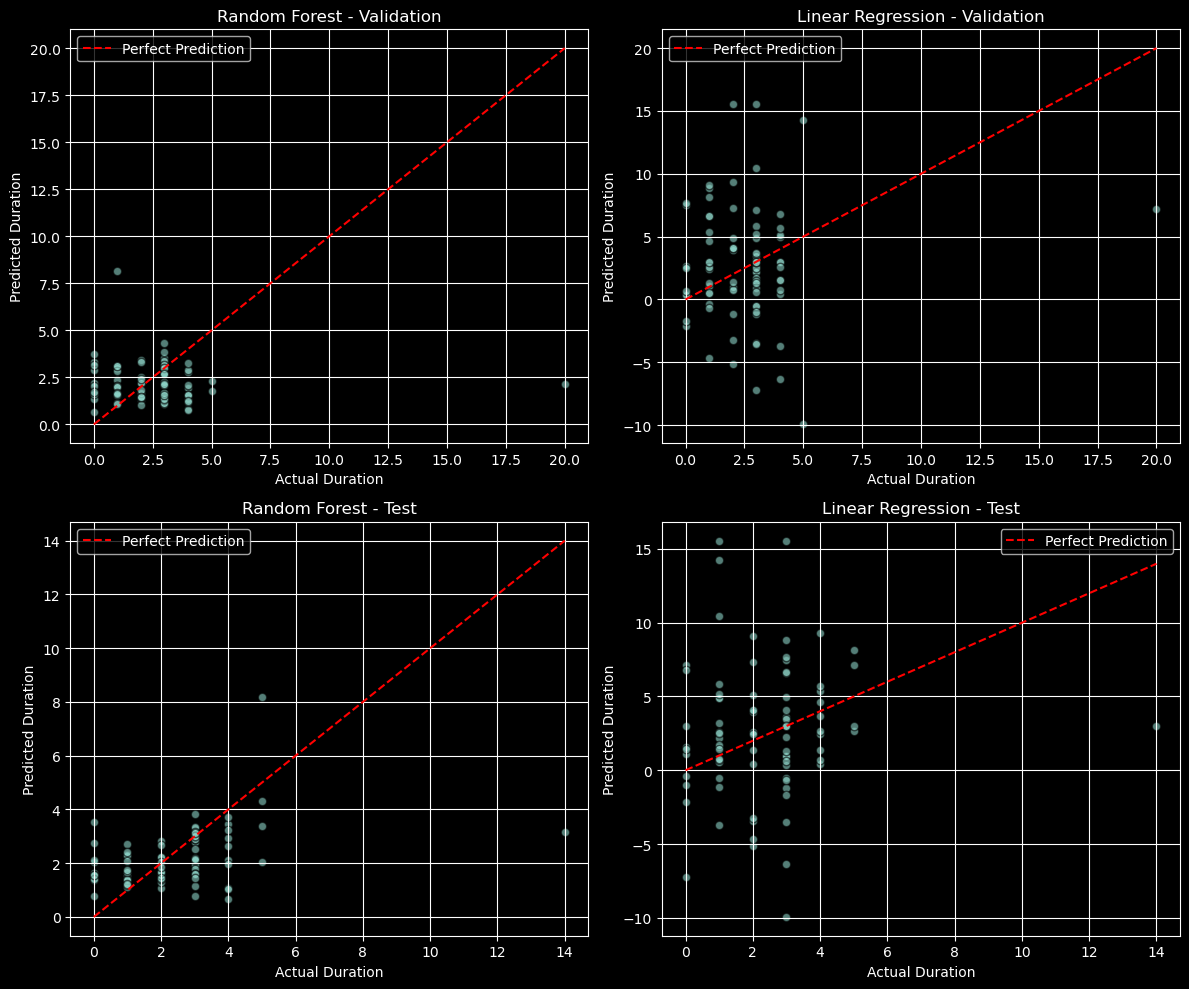

In [12]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Random Forest - Validation
axs[0, 0].scatter(y_val_years, y_pred_years_gs, alpha=0.6, edgecolors='k')
axs[0, 0].plot([y_val_years.min(), y_val_years.max()], [y_val_years.min(), y_val_years.max()], 'r--', label='Perfect Prediction')
axs[0, 0].set_title('Random Forest - Validation')
axs[0, 0].set_xlabel('Actual Duration')
axs[0, 0].set_ylabel('Predicted Duration')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Linear Regression - Validation
axs[0, 1].scatter(y_val_years, y_pred_years_log, alpha=0.6, edgecolors='k')
axs[0, 1].plot([y_val_years.min(), y_val_years.max()], [y_val_years.min(), y_val_years.max()], 'r--', label='Perfect Prediction')
axs[0, 1].set_title('Linear Regression - Validation')
axs[0, 1].set_xlabel('Actual Duration')
axs[0, 1].set_ylabel('Predicted Duration')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Random Forest - Test
y_test_pred_rf = grid_rm_reg.predict(X_test_years)
axs[1, 0].scatter(y_test_years, y_test_pred_rf, alpha=0.6, edgecolors='k')
axs[1, 0].plot([y_test_years.min(), y_test_years.max()], [y_test_years.min(), y_test_years.max()], 'r--', label='Perfect Prediction')
axs[1, 0].set_title('Random Forest - Test')
axs[1, 0].set_xlabel('Actual Duration')
axs[1, 0].set_ylabel('Predicted Duration')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Linear Regression - Test
y_test_pred_lr = lin_reg.predict(X_test_years)
axs[1, 1].scatter(y_test_years, y_test_pred_lr, alpha=0.6, edgecolors='k')
axs[1, 1].plot([y_test_years.min(), y_test_years.max()], [y_test_years.min(), y_test_years.max()], 'r--', label='Perfect Prediction')
axs[1, 1].set_title('Linear Regression - Test')
axs[1, 1].set_xlabel('Actual Duration')
axs[1, 1].set_ylabel('Predicted Duration')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Final layout adjustment
plt.tight_layout()
plt.show()

### Regressional model results ###
From the results of the two models we can see that not only does Random Forest have better score by RMSE/ MAE, but when plotting the models we can see that the points are closer to perfect prediction line, which means that Random Forest could be the best performing model. But the spread is not that high for the random forest model predicting on test which can mean that it is overfitted.

In [13]:
import joblib

#modell tränas på hela datasetet
X = df_oh
y = y_encoded
X = scaler.fit_transform(X)
best_model = best_model.fit(X, y)
lin_reg.fit(X, y)

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(df_oh, "features.pkl")
joblib.dump(y_encoded, "targets.pkl")
joblib.dump(lin_reg, "reg_model.pkl")

['reg_model.pkl']